# Introduction

In [20]:
# LOCATION : https://github.com/facebookresearch/dinov2/issues/23
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

patch_h = 40
patch_w = 40
feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

transform = T.Compose([
    T.GaussianBlur(9, sigma=(0.1, 2.0)),
    T.Resize((patch_h * 14, patch_w * 14)),
    T.CenterCrop((patch_h * 14, patch_w * 14)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').cuda()
# dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

#print(dinov2_vits14)


Using cache found in /home/osero/.cache/torch/hub/facebookresearch_dinov2_main


# extract features

In [21]:

# extract features
features = torch.zeros(4, patch_h * patch_w, feat_dim)
imgs_tensor = torch.zeros(4, 3, patch_h * 14, patch_w * 14)
for i in range(4):
    img_path = f'dino_test_imgs/elephant_{i+1}.png'
    img = Image.open(img_path).convert('RGB')
    imgs_tensor[i] = transform(img)[:3]
with torch.no_grad():
    features_dict = dinov2_vits14.forward_features(imgs_tensor.cuda())
    features = features_dict['x_norm_patchtokens']


# PCA for feature inferred

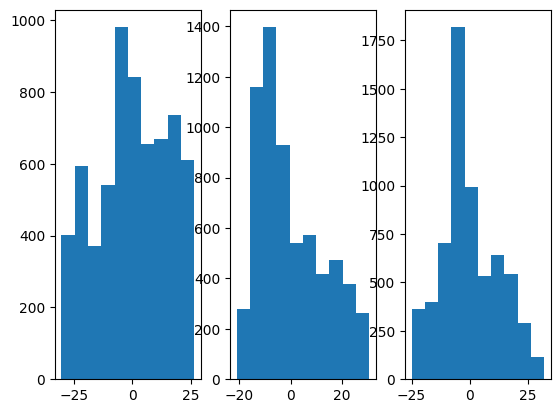

In [22]:

# PCA for feature inferred
from sklearn.decomposition import PCA

features = features.reshape(4 * patch_h * patch_w, feat_dim).cpu()

pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

# visualize PCA components for finding a proper threshold
plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0])
plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1])
plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

# uncomment below to plot the first pca component
# pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(pca_features[i * patch_h * patch_w: (i+1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
# plt.show()
# plt.close()

# segment using the first component

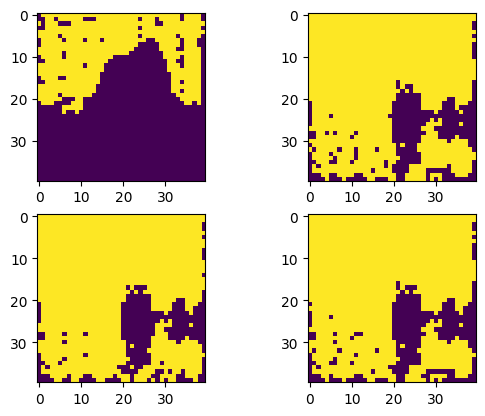

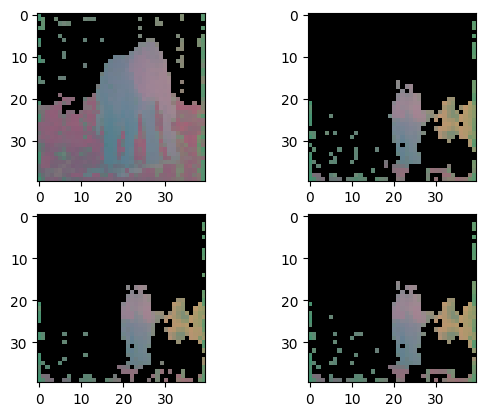

In [23]:
# segment using the first component
pca_features_bg = pca_features[:, 0] < 10
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

# PCA for only foreground patches
pca.fit(features[pca_features_fg]) # NOTE: I forgot to add it in my original answer
pca_features_rem = pca.transform(features[pca_features_fg])
for i in range(3):
    # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
    # transform using mean and std, I personally found this transformation gives a better visualization
    pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_rem

pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i][..., ::-1])
plt.savefig('features.png')
plt.show()
plt.close()